In [6]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import candel
from candel import SPEED_OF_LIGHT

from utils import *

from scipy.stats import norm
from astropy.cosmology import FlatLambdaCDM
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

root = "/Users/rstiskalek/Projects/CANDEL/results/CH0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path)

2025-07-01 12:59:58 warning: zero width found in the priors. Setting it to 1e-5.
2025-07-01 12:59:58 indices of zero width: [44]
2025-07-01 12:59:58 found zero-width prior at index 44. Setting it to 0.


### Hubble diagrams Cepheid-only Hubble diagrams

In [3]:
# Read-in the data
mu_host_r2 = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "mu_host")
mu_host_unif = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "mu_host")

mu_host_r2_mean = np.mean(mu_host_r2, axis=0)
mu_host_unif_mean = np.mean(mu_host_unif, axis=0)

mu_host_r2_err = np.std(mu_host_r2, axis=0)
mu_host_unif_err = np.std(mu_host_unif, axis=0)

cz = data["czcmb_cepheid_host"]
cz_err = np.ones_like(cz) * 270

# Prepare the Hubble diagram plots
czrange = np.linspace(450, 5100, 1000)
zrange = czrange / SPEED_OF_LIGHT

cosmo_SH0ES = FlatLambdaCDM(H0=73.04, Om0=0.3)
mu_SH0ES = cosmo_SH0ES.distmod(czrange / SPEED_OF_LIGHT).value

cosmo_Planck = FlatLambdaCDM(H0=67.4, Om0=0.3)
mu_Planck = cosmo_Planck.distmod(czrange / SPEED_OF_LIGHT).value

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_68005/2815319929.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


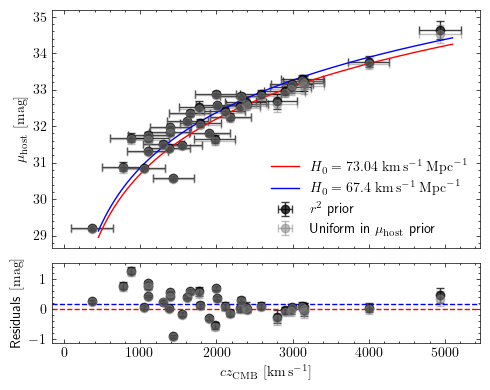

In [4]:
# Compute SH0ES model predictions at the data cz points
mu_SH0ES_cz = np.interp(cz, czrange, mu_SH0ES)
mu_Planck_cz = np.interp(cz, czrange, mu_Planck)
mu_Planck_residual = mu_Planck_cz - mu_SH0ES_cz

# Start figure with two panels: main plot and residuals
with plt.style.context("science"):
    fig, (ax_main, ax_resid) = plt.subplots(
        2, 1, figsize=(5, 4),
        gridspec_kw={"height_ratios": [3, 1],}, sharex=True
    )

    # Main panel
    ax_main.errorbar(
        cz, mu_host_r2_mean, xerr=cz_err, yerr=mu_host_r2_err,
        fmt="o", color="black", label=r"$r^2$ prior", capsize=3, alpha=0.75
    )
    ax_main.errorbar(
        cz, mu_host_unif_mean, xerr=cz_err, yerr=mu_host_unif_err,
        fmt="o", color="gray", label=r"Uniform in $\mu_{\rm host}$ prior", capsize=3, alpha=0.5
    )
    ax_main.plot(
        czrange, mu_SH0ES, color="red", label=r"$H_0 = 73.04~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )
    ax_main.plot(
        czrange, mu_Planck, color="blue", label=r"$H_0 = 67.4~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )

    ax_main.set_ylabel(r"$\mu_{\rm host} ~ [\mathrm{mag}]$")
    ax_main.legend()

    # Residual panel
    resid_r2 = mu_host_r2_mean - mu_SH0ES_cz
    resid_unif = mu_host_unif_mean - mu_SH0ES_cz
    ax_resid.errorbar(
        cz, resid_r2, yerr=mu_host_r2_err,
        fmt="o", color="black", capsize=3, alpha=0.75
    )
    ax_resid.errorbar(
        cz, resid_unif, yerr=mu_host_unif_err,
        fmt="o", color="gray", capsize=3, alpha=0.5
    )

    # Planck-SH0ES residual line
    ax_resid.axhline(mu_Planck_residual.mean(), color="blue", ls="--")

    ax_resid.axhline(0, color="red", ls="--")
    ax_resid.set_xlabel(r"$c z_{\rm CMB} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")
    ax_resid.set_ylabel(r"Residuals $[\mathrm{mag}]$")

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/mu_host_cz_residual.pdf", dpi=500, bbox_inches="tight")
    fig.show()

### Comparison of Cepheid-only distance

SH0ES_fiducial.hdf5: H0, M_B, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_mu_uniform.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_r2_prior.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Removed no burn in
Removed no burn in
Removed no burn in
2025-06-30 11:44:45 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/anchor_distances.pdf


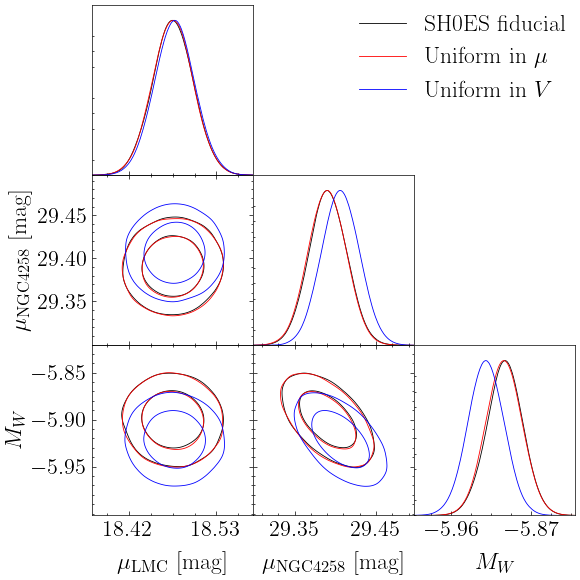

In [63]:
fnames = [
    "SH0ES_fiducial.hdf5",
    "Cepheid_distances_mu_uniform.hdf5",
    "Cepheid_distances_r2_prior.hdf5",
]
labels = [
    "SH0ES fiducial",
    r"Uniform in $\mu$",
    r"Uniform in $V$",
]

fnames = [join(root, fname) for fname in fnames]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["mu_LMC", "mu_N4258", "M_W"],
    labels=labels,
    filled=False,
    fontsize=20,
    filename="/Users/rstiskalek/Downloads/anchor_distances.pdf",
    )

### M_W calibration

In [5]:
M_HST, e_M_HST = data["M_HST"], data["e_M_HST"]
M_Gaia, e_M_Gaia = data["M_Gaia"], data["e_M_Gaia"]

print("M_HST: ", M_HST, "±", e_M_HST)
print("M_Gaia: ", M_Gaia, "±", e_M_Gaia)

M_HST:  -5.803876 ± 0.08194048719540387
M_Gaia:  -5.9034147 ± 0.025000005541368706


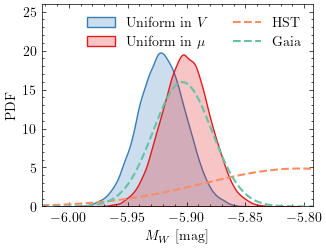

In [45]:
M_HST, e_M_HST = data["M_HST"], data["e_M_HST"]
M_Gaia, e_M_Gaia = data["M_Gaia"], data["e_M_Gaia"]
samples_r2 = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "M_W")
samples_uniform = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "M_W")

with plt.style.context("science"):
    plt.figure()
    lw = plt.rcParams["lines.linewidth"]

    # Plot KDEs instead of histograms
    sns.kdeplot(samples_r2, fill=True, label=r"Uniform in $V$", color="#377eb8", zorder=-1)
    sns.kdeplot(samples_uniform, fill=True, label=r"Uniform in $\mu$", color="#e41a1c", zorder=-1)

    # Plot Gaussian priors for HST and Gaia
    xlim = plt.xlim()
    x = np.linspace(*xlim, 500)

    plt.plot(x, norm.pdf(x, loc=M_HST, scale=e_M_HST), color="#fc8d62", label="HST", ls="--" , lw=1.5 * lw)
    plt.plot(x, norm.pdf(x, loc=M_Gaia, scale=e_M_Gaia), color="#66c2a5", label="Gaia", ls="--", lw=1.5 * lw)

    plt.xlim(*xlim)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, ymax * 1.25)  # Increase by 20%

    plt.xlabel(r"$M_W ~ [\mathrm{mag}]$")
    plt.ylabel(r"PDF")

    plt.legend(ncols=2)
    plt.savefig("/Users/rstiskalek/Downloads/M_W_distributions.pdf", dpi=500, bbox_inches="tight")
    plt.show()


### NGC 4258 calibration

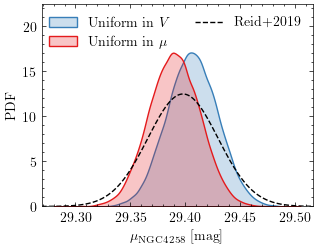

In [60]:
mean = data["mu_N4258_anchor"]
err = data["e_mu_N4258_anchor"]

samples_r2 = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "mu_N4258")
samples_uniform = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "mu_N4258")

with plt.style.context("science"):
    plt.figure()
    lw = plt.rcParams["lines.linewidth"]

    # Plot KDEs instead of histograms
    sns.kdeplot(samples_r2, fill=True, label=r"Uniform in $V$", color="#377eb8", zorder=-1)
    sns.kdeplot(samples_uniform, fill=True, label=r"Uniform in $\mu$", color="#e41a1c", zorder=-1)

    # Plot Gaussian priors for HST and Gaia
    xlim = plt.xlim()
    x = np.linspace(*xlim, 500)

    plt.plot(x, norm.pdf(x, loc=mean, scale=err), color="black", label="Reid+2019", ls="--")
    # plt.plot(x, norm.pdf(x, loc=M_Gaia, scale=e_M_Gaia), color="#66c2a5", label="Gaia", ls="--", lw=1.5 * lw)

    plt.xlim(*xlim)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, ymax * 1.25)  # Increase by 20%

    plt.xlabel(r"$\mu_{\rm NGC4258} ~ [\mathrm{mag}]$")
    plt.ylabel(r"PDF")

    plt.legend(ncols=2)
    plt.savefig("/Users/rstiskalek/Downloads/mu_NGC4258.pdf", dpi=500, bbox_inches="tight")
    plt.show()


### Cepheid-host galaxies distance comparison

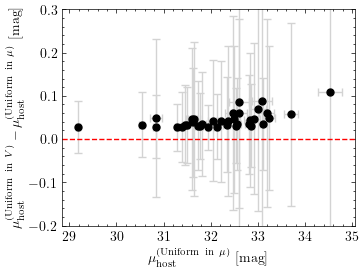

dx = 0.0445 ± 0.1455


In [48]:
samples_r2 = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "mu_host")
samples_unif = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "mu_host")

ntot = 37

X = {f"mu_{i}": samples_unif[:, i] for i in range(ntot)}
Y = {f"mu_{i}": samples_r2[:, i] for i in range(ntot)}

x_mean = np.asarray([np.mean(X[f"mu_{i}"]) for i in range(ntot)])
x_err = np.asarray([np.std(X[f"mu_{i}"]) for i in range(ntot)])

dx_mean = np.asarray([np.mean(Y[f"mu_{i}"]) - np.mean(X[f"mu_{i}"]) for i in range(ntot)])
dx_err = np.asarray([np.sqrt(np.var(Y[f"mu_{i}"]) + np.var(X[f"mu_{i}"])) for i in range(ntot)])

with plt.style.context("science"):
    plt.figure()
    plt.errorbar(x_mean, dx_mean, xerr=x_err, yerr=dx_err, fmt='o', color='black',
                 ecolor='lightgray',  capsize=3, ms=5)
    plt.axhline(0, color="red", linestyle="--", label="No difference")
    plt.xlabel(r"$\mu_{\rm host}^{(\mathrm{Uniform~in~}\mu)} ~ [\mathrm{mag}]$")
    plt.ylabel(r"$\mu_{\rm host}^{(\mathrm{Uniform~in~}V)} - \mu_{\rm host}^{(\mathrm{Uniform~in~}\mu)} ~ [\mathrm{mag}]$")
    plt.ylim(-0.2, 0.3)
    plt.tight_layout(pad=0)
    plt.savefig("/Users/rstiskalek/Downloads/mu_host.pdf", bbox_inches='tight')

    plt.show()


print(f"dx = {dx_mean.mean():.4f} ± {dx_err.mean():.4f}")

### Cepheid-only inferred $H_0$ 

SH0ES_fiducial.hdf5: H0, M_B, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_redshift_r2_PVcov.hdf5: H0, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v
Removed no burn in
Removed no burn in
2025-06-16 13:11:11 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/anchor_distances.pdf


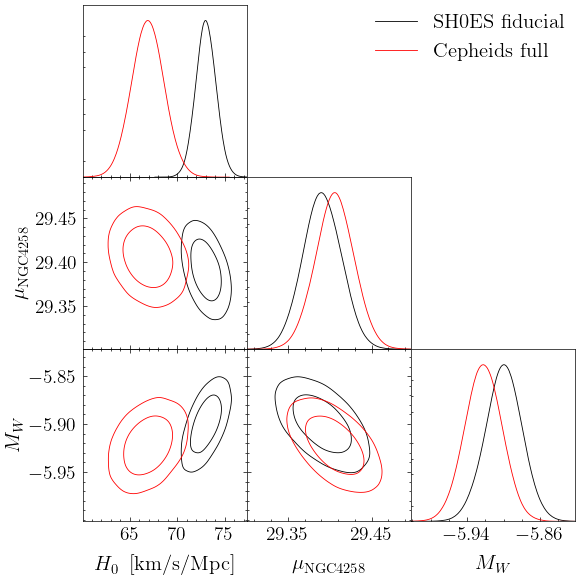

In [ ]:
fnames = [
    "SH0ES_fiducial.hdf5",
    "Cepheid_distances_redshift_r2_PVcov.hdf5",
]
labels = [
    "SH0ES fiducial",
    # r"Cepheids only (uniform in volume prior)",
    # r"Cepheids only (uniform in $\mu$ prior)",
    r"Cepheids full",
]

fnames = [join(root, fname) for fname in fnames]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["H0", "mu_N4258", "M_W"],
    labels=labels,
    filled=False,
    fontsize=18,
    filename="/Users/rstiskalek/Downloads/anchor_distances.pdf",
    )

### Comparison corner-plot

Cepheid_H0_Vext_sigma_v.hdf5: H0, M_W, Vext, Vext_b, Vext_ell, Vext_mag, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v
Cepheid_H0_PV_covmat_scaled.hdf5: A_covmat, H0, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v
Cepheid_H0_C15_MNR.hdf5: H0, M_W, Vext, Vext_b, Vext_ell, Vext_mag, Z_W, b_W, beta, dZP, mean_OH_all, mean_OH_per_host, mean_logP_all, mean_logP_per_host, mean_std_OH, mean_std_logP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v, std_OH_all, std_OH_per_host, std_logP_all, std_logP_per_host
Removed no burn in
Removed no burn in
Removed no burn in
2025-06-20 11:36:38 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/H0_corner.pdf


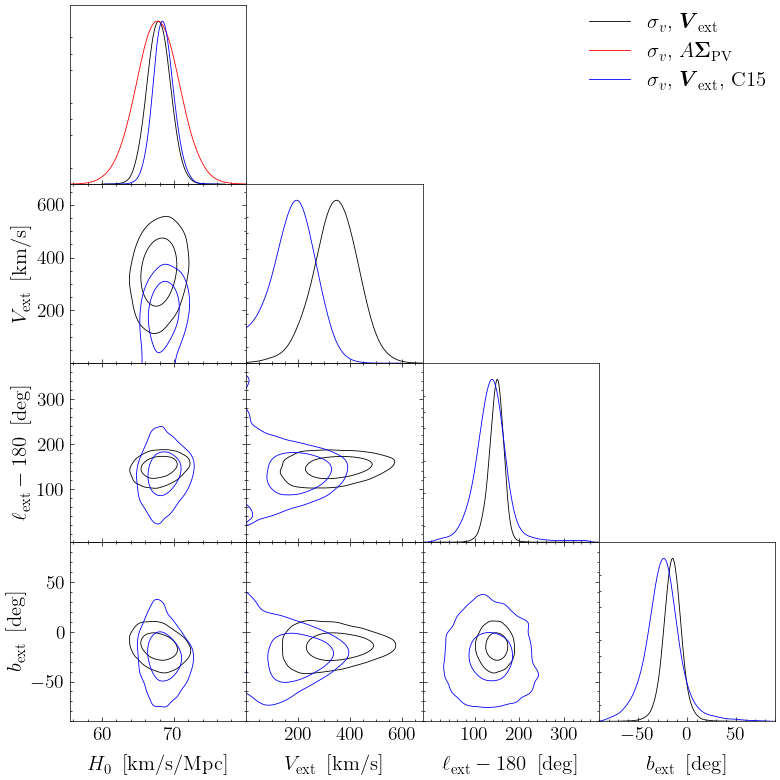

In [126]:
fnames = [
    "Cepheid_H0_Vext_sigma_v.hdf5",
    "Cepheid_H0_PV_covmat_scaled.hdf5",
    "Cepheid_H0_C15_MNR.hdf5",
    ]

labels = [
    r"$\sigma_v,\,\boldsymbol{V}_{\rm ext}$",
    r"$\sigma_v,\,A \boldsymbol{\Sigma}_{\rm PV}$",
    r"$\sigma_v,\,\boldsymbol{V}_{\rm ext}$, C15",
    ]



fnames = [join(root, fname) for fname in fnames]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["H0", "Vext_mag", "Vext_ell", "Vext_b",],
    labels=labels,
    filled=False,
    apply_ell_offset=True,
    ell_range=[None, None],
    filename="/Users/rstiskalek/Downloads/H0_corner.pdf",
    fontsize=18,
    )

### C15 all-parameters

Cepheid_H0_C15_MNR.hdf5: H0, M_W, Vext, Vext_b, Vext_ell, Vext_mag, Z_W, b_W, beta, dZP, mean_OH_all, mean_OH_per_host, mean_logP_all, mean_logP_per_host, mean_std_OH, mean_std_logP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v, std_OH_all, std_OH_per_host, std_logP_all, std_logP_per_host
Removed no burn in


<string>:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2025-07-01 17:15:23 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/C15_corner.pdf


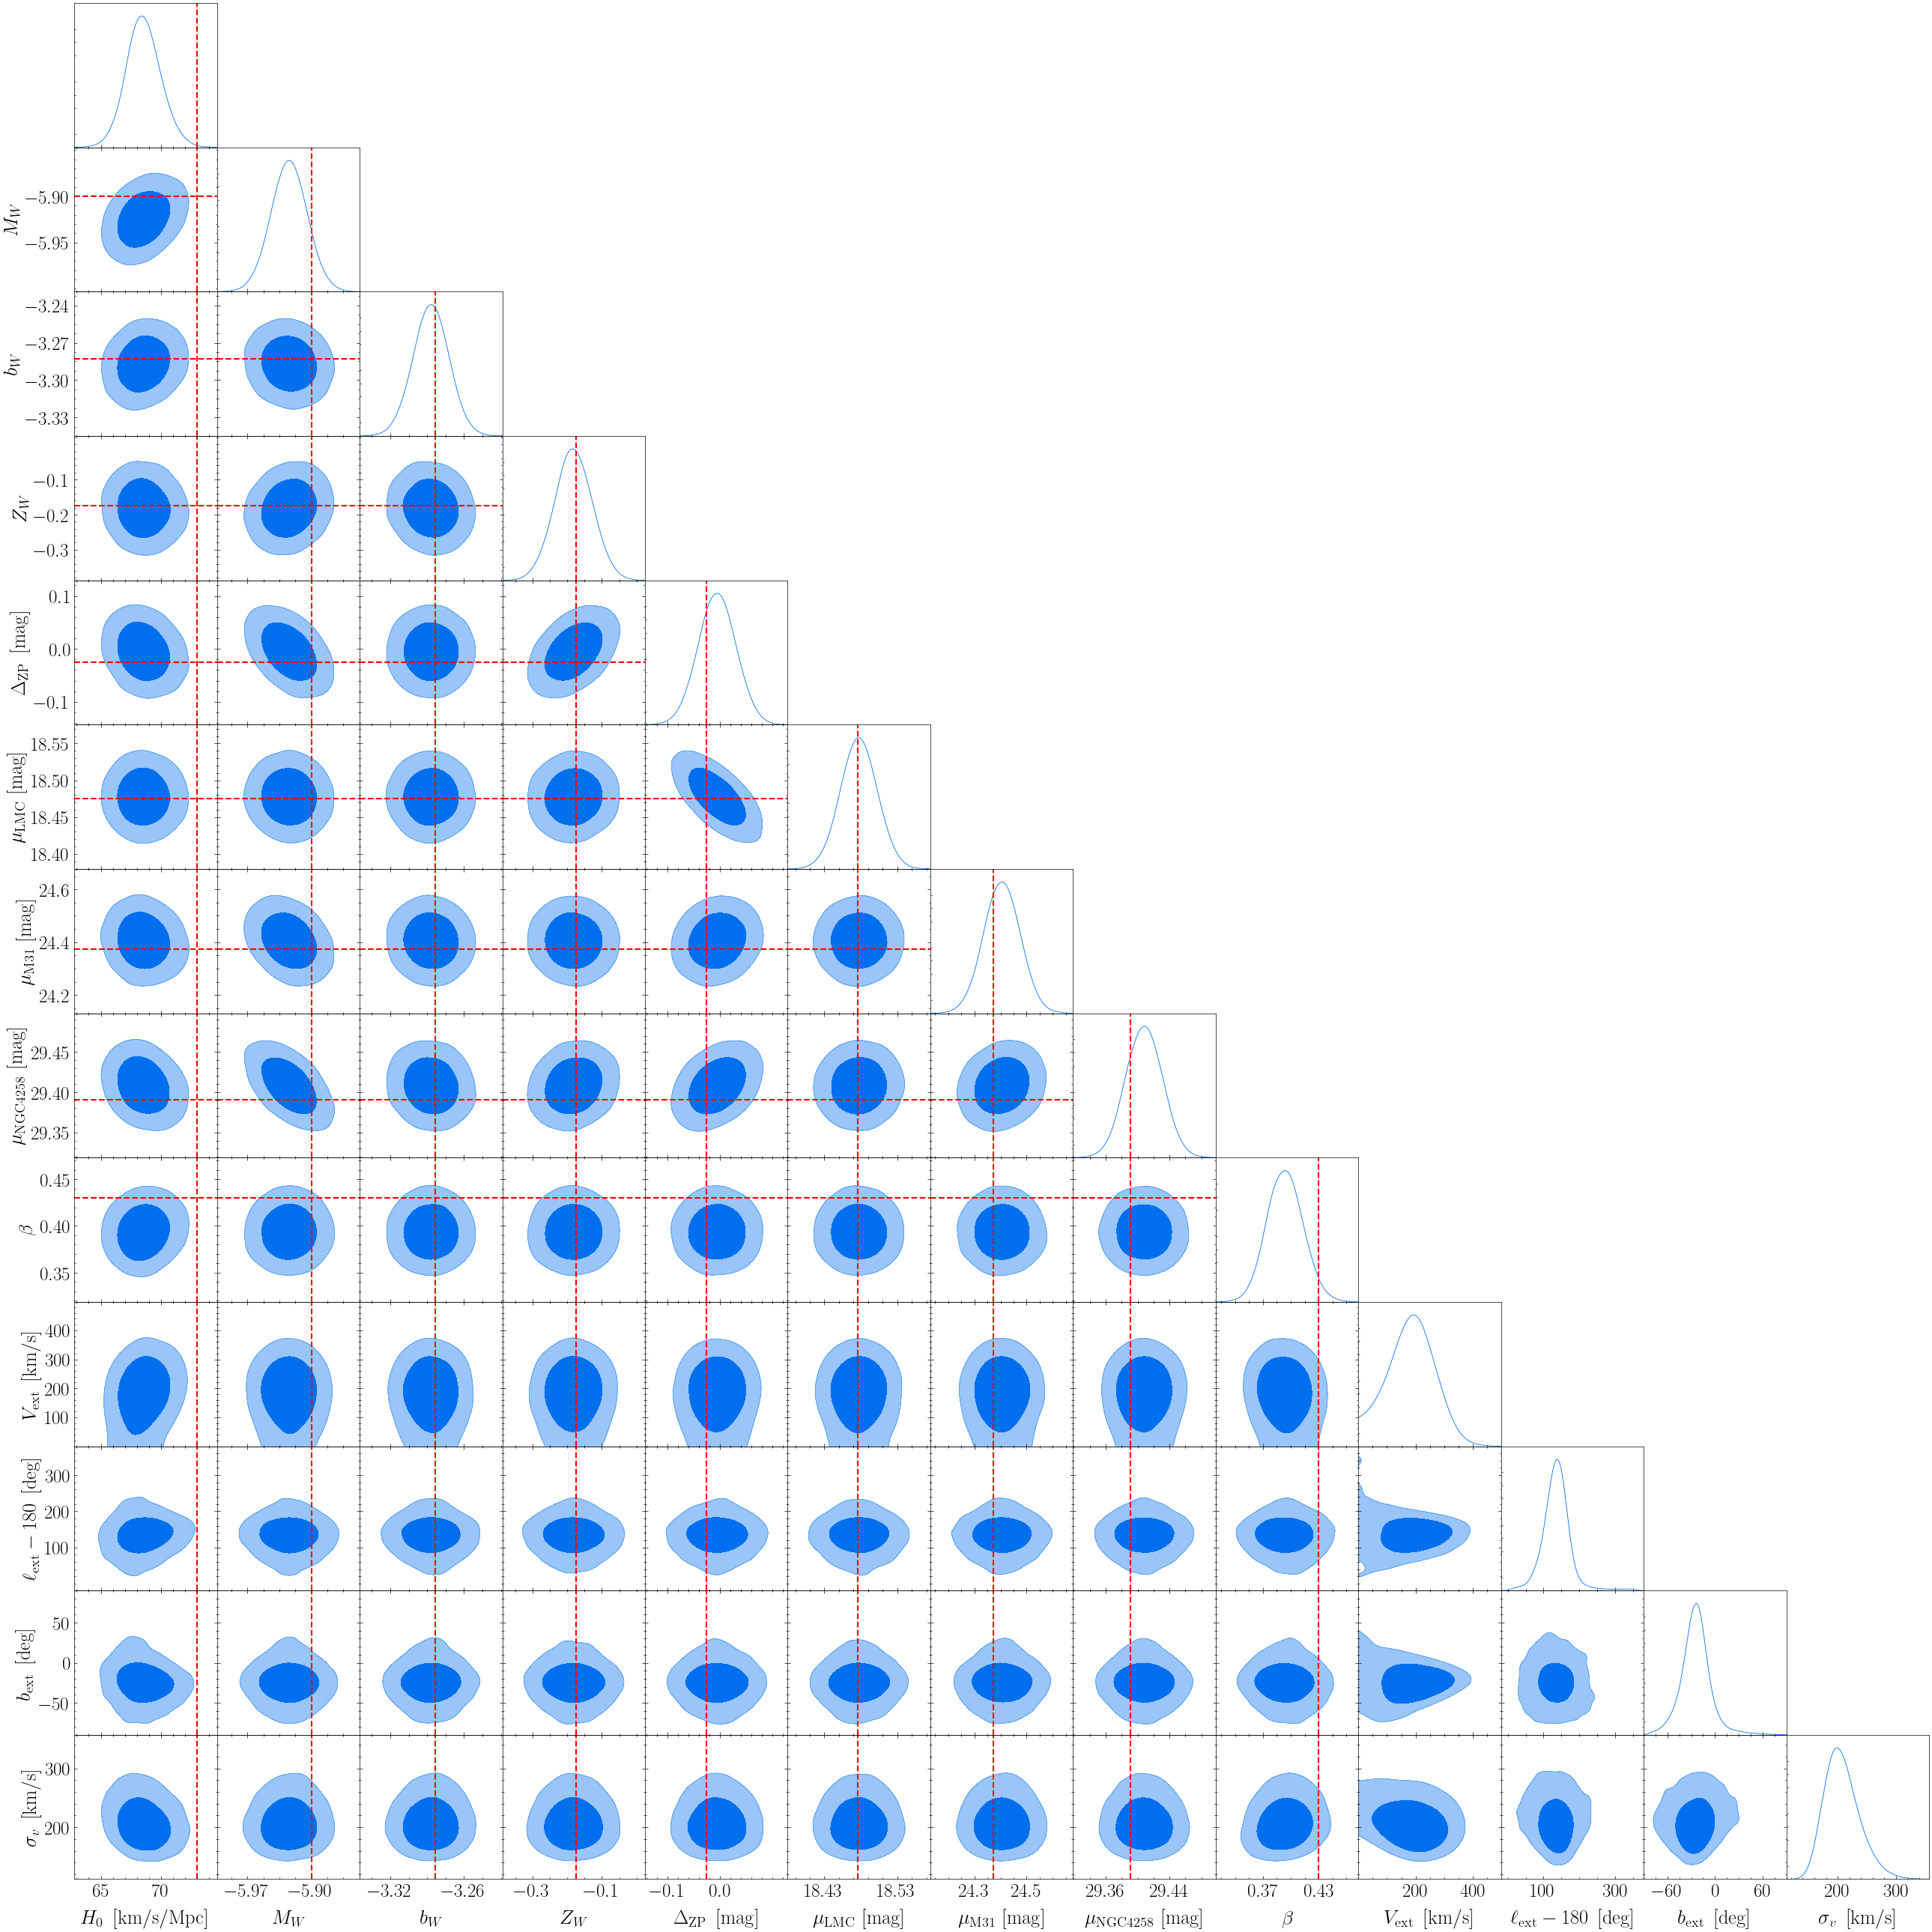

In [83]:
fnames = [
    "Cepheid_H0_C15_MNR.hdf5",
    ]

labels = None

fnames = [join(root, fname) for fname in fnames]

truths = {"H0": 73.02759, "M_W": -5.8999543, "b_W": -3.2831473,
          "Z_W": -0.17501639, "dZP": -0.025033418, "mu_LMC": 18.475368,
          "mu_N4258": 29.390965, "mu_M31": 24.373648, "beta": 0.43}

candel.plot_corner_from_hdf5(
    fnames,
    keys=["H0", "M_W", "b_W", "Z_W", "dZP", "mu_LMC", "mu_M31", "mu_N4258", "beta", "Vext_mag", "Vext_ell", "Vext_b", "sigma_v"],
    labels=labels,
    apply_ell_offset=True,
    ell_range=[None, None],
    filename="/Users/rstiskalek/Downloads/C15_corner.pdf",
    fontsize=22,
    truths=truths,
    )

### Comparison of all inferred $H_0$ values

In [64]:
fnames = [
    # "Cepheid_H0_sigma_v.hdf5",
    # "Cepheid_H0_Vext_sigma_v.hdf5",
    # "Cepheid_H0_PV_covmat.hdf5",
    # "Cepheid_H0_PV_covmat_scaled.hdf5",
    "Cepheid_H0_C15.hdf5",
]
labels = [
    # r"$\sigma_v$",
    # r"$\sigma_v,\,\boldsymbol{V}_{\rm ext}$",
    # r"$\sigma_v,\,\boldsymbol{\Sigma}_{\rm PV}$",
    # r"$\sigma_v,\,A \boldsymbol{\Sigma}_{\rm PV}$",
    r"$\sigma_v,\,\boldsymbol{V}_{\rm ext}$, C15",
    # r"Cepheids only (uniform in volume prior)",
    # r"Cepheids only (uniform in $\mu$ prior)",
    # r"Cepheids full",
]


samples = [read_samples(root, fname, "H0") for fname in fnames]

In [66]:
x = samples[0]

x.mean(), x.std()

(68.5731, 1.4567436)

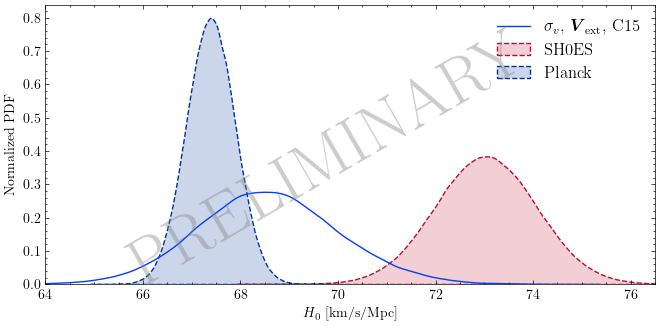

In [14]:
fig_width = 6.8  # in inches
fig_height = 3.5

filtered_palette = sns.color_palette("bright")
# filtered_palette = set1_palette[2:]  # skip red (0) and blue (1)

with plt.style.context("science"):
    plt.figure(figsize=(fig_width, fig_height))

    for i in range(len(samples)):
        sns.kdeplot(
            samples[i],
            label=labels[i],
            fill=False,
            color=filtered_palette[i % len(filtered_palette)]
        )

    sns.kdeplot(
        norm(73.04, 1.04).rvs(size=500000),
        label="SH0ES",
        fill=True,
        alpha=0.2,
        ls="--",
        color="#BF0A30",
        zorder=-1,
    )
    sns.kdeplot(
        norm(67.4, 0.5).rvs(size=500000),
        label="Planck",
        fill=True,
        alpha=0.2,
        ls="--",
        color="#003399",
        zorder=-1,
    )

    plt.text(
    0.5, 0.5, "PRELIMINARY",
    fontsize=48, color='gray', alpha=0.4,
    ha='center', va='center', zorder=10,
    transform=plt.gcf().transFigure, rotation=30)

    plt.xlabel(r"$H_0 ~ [\mathrm{km}/\mathrm{s}/\mathrm{Mpc}]$")
    plt.ylabel("Normalized PDF")
    plt.legend(ncol=1, fontsize="large")
    plt.xlim(64, 76.5)
    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/H0_comparison_B.pdf", dpi=500, bbox_inches="tight")
    plt.show()

In [84]:
# x = read_samples(root, "Cepheid_distances_r2_prior.hdf5", "mu_N4258")
# x = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "mu_N4258")
x = read_samples(root, "SH0ES_fiducial.hdf5", "mu_host")

# x.mean(), x.std()

In [90]:
x[:, 0].std()

0.039587677

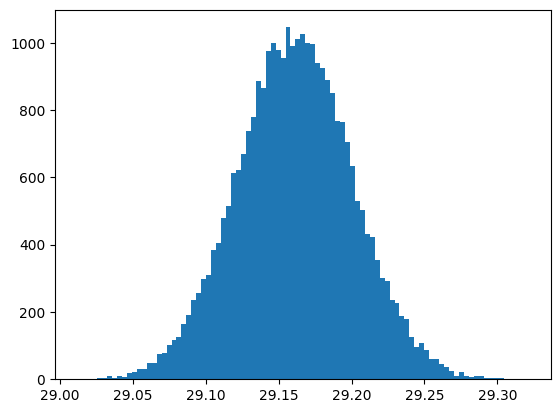

In [88]:
plt.figure()
plt.hist(x[:, 0], bins="auto")
plt.show()

In [63]:
29.387 + 0.00856

29.39556

In [41]:
(29.406357 - 29.390036)  / 0.023164261

0.7045767615898199

In [ ]:
(29.390036, 0.02320611)

{'A_covmat': array([1.0068883, 1.2296764, 1.050108 , ..., 1.1200849, 1.2453475,
        1.0074599], dtype=float32),
 'H0': array([66.251144, 68.68274 , 68.09114 , ..., 68.988716, 66.54725 ,
        67.010284], dtype=float32),
 'M_W': array([-5.887863 , -5.969678 , -5.955756 , ..., -5.957978 , -5.940194 ,
        -5.9233484], dtype=float32),
 'Z_W': array([-0.14601648, -0.24969459, -0.17832446, ..., -0.24659014,
        -0.24251056, -0.20167792], dtype=float32),
 'b_W': array([-3.2939887, -3.2818975, -3.2787418, ..., -3.2705421, -3.276505 ,
        -3.291234 ], dtype=float32),
 'dZP': array([-0.04682525,  0.03513318,  0.0401937 , ...,  0.01574068,
         0.01761054,  0.02050023], dtype=float32),
 'mu_LMC': array([18.492857, 18.466623, 18.474642, ..., 18.470268, 18.448547,
        18.451937], dtype=float32),
 'mu_M31': array([24.364208, 24.361563, 24.330856, ..., 24.370644, 24.419823,
        24.460966], dtype=float32),
 'mu_N4258': array([29.403936, 29.460613, 29.409685, ..., 29.44182

In [72]:
from scipy.stats import norm
import posterior_agreement

x = read_samples(root, "Cepheid_H0_Vext_sigma_v.hdf5", "H0")
H0_planck = norm(67.4, 0.5).rvs(50000)
H0_SH0ES = norm(73.04, 1.04).rvs(50000)

print(x.mean(), x.std())

chains = (H0_SH0ES, x)
agreement_1d = posterior_agreement.compute_agreement(chains)
print("SH0ES: p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

chains = (H0_planck, x)
agreement_1d = posterior_agreement.compute_agreement(chains)
print("Planck: p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

67.917816 1.6434653
SH0ES: p-value 0.010, corresponding to 2.5787 sigmas
Planck: p-value 0.754, corresponding to 0.3137 sigmas
